# Curso de Manejo de Datos Faltantes: Imputación

[![Curso creado por jvelezmagic](https://img.shields.io/badge/Desarrollado%20por-%40jvelezmagic-blue?&style=for-the-badge&logo=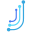)](https://jvelezmagic.com/)

![Curso de Manejo de Datos Faltantes: Exploración](course-logo.jpg)

## Configuración de ambiente de trabajo

```bash
pip install --upgrade pip
```

```bash
pip install pyjanitor matplotlib missingno nhanes pandas scipy seaborn session-info sklearn statsmodels upsetplot
```

or 

```bash
pip install -r requirements.txt
```

## Importar librerías

In [81]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

## Importar funciones personalizadas

In [8]:
%run pandas-missing-extension.py

## Configurar el aspecto general de las gráficas del proyecto

In [9]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

## El problema de trabajar con valores faltantes

### Reto: Datos de supervivientes

In [10]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data

Ajusta algunos modelos utilizando a las variables con valores faltantes como predictoras. ¿Qué sucede?

In [ ]:
# Aquí tu código...

## Preparando datos: _National Health and Nutrition Examination Survey_

c:\Users\Admin\Documents\manejo_datos\Data-Handling-Course\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)
c:\Users\Admin\Documents\manejo_datos\Data-Handling-Course\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)
c:\Users\Admin\Documents\manejo_datos\Data-Handling-Course\venv\Lib\site-packages\upsetplot\plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

(7157, 8)

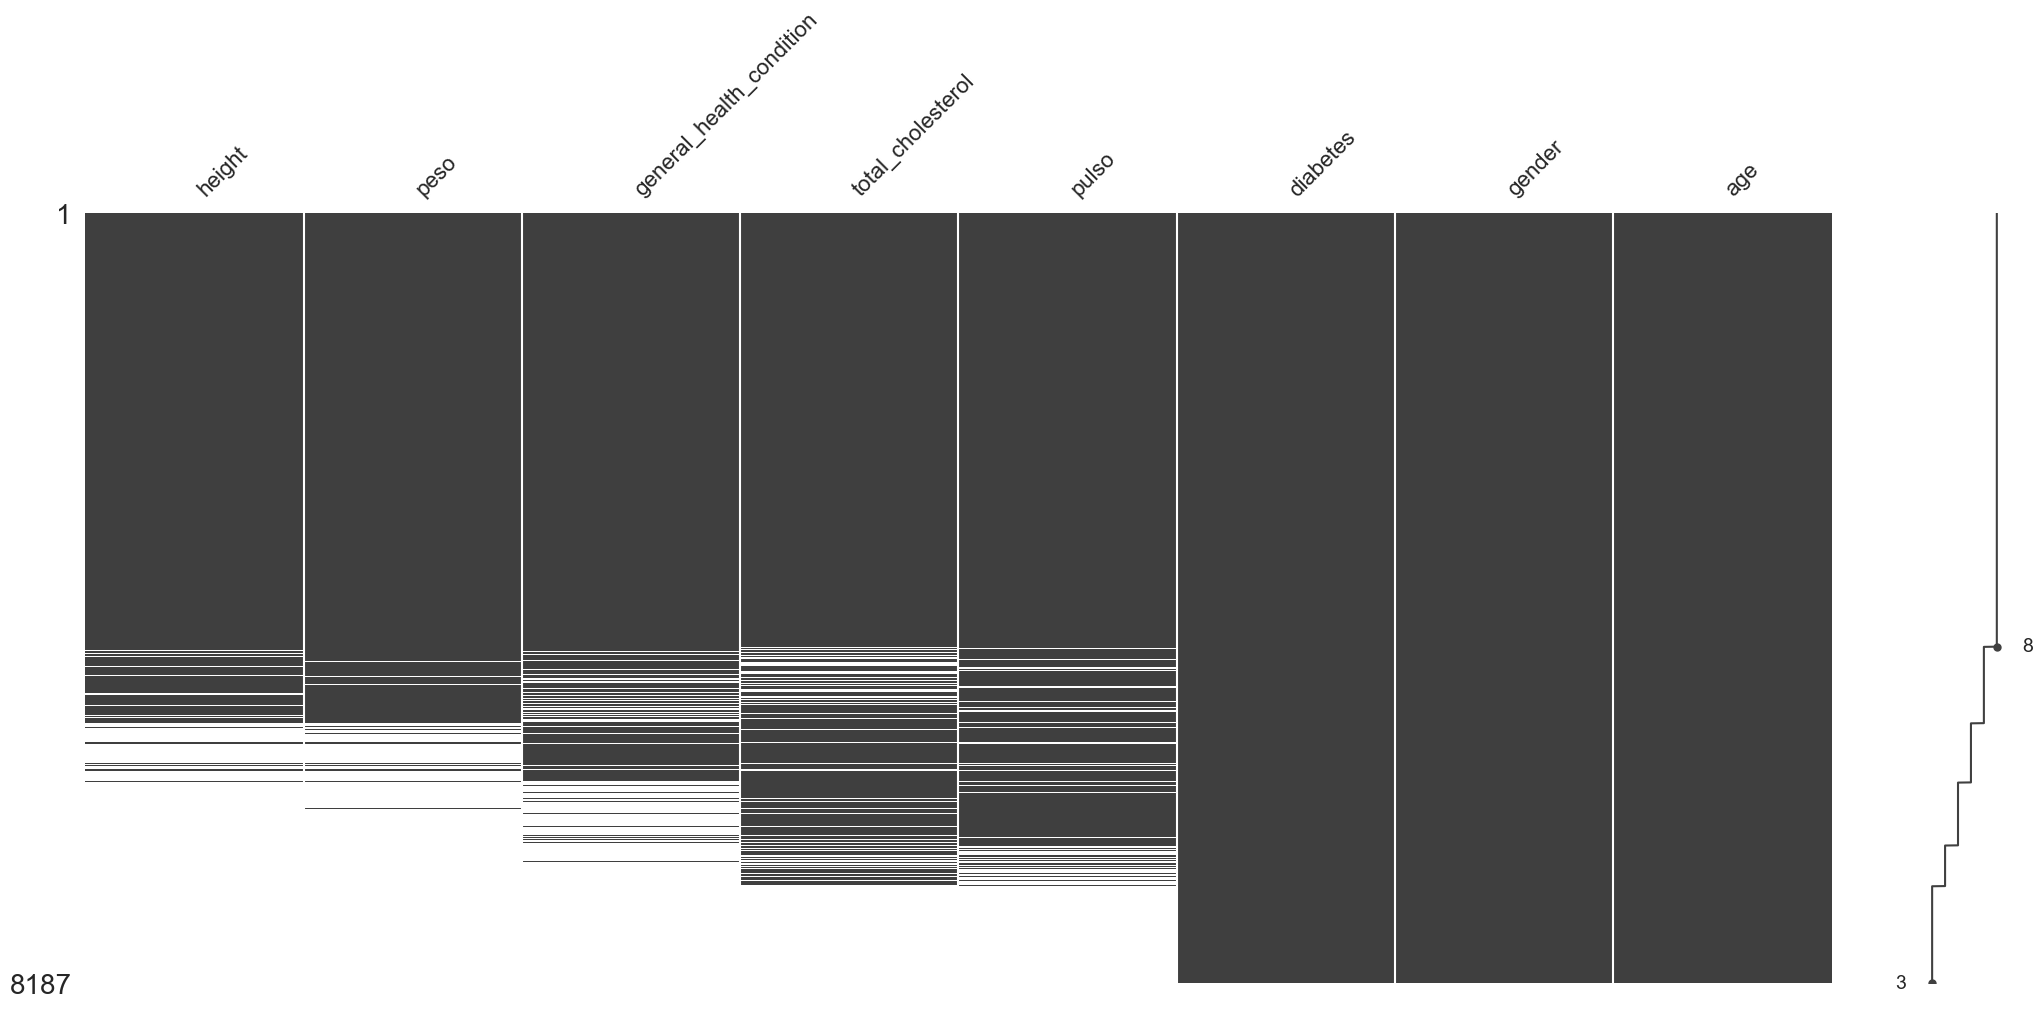

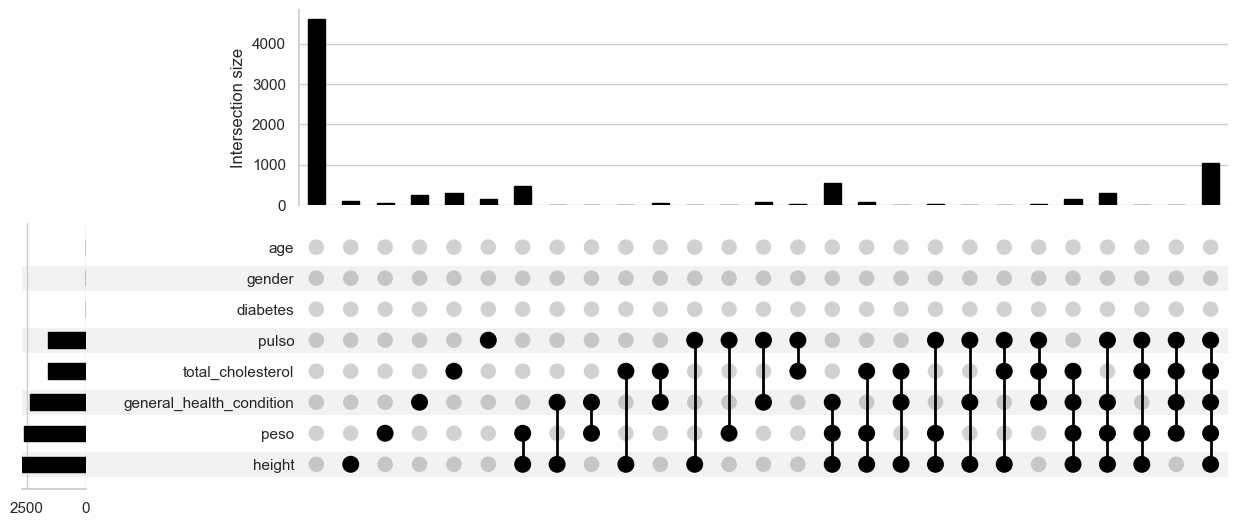

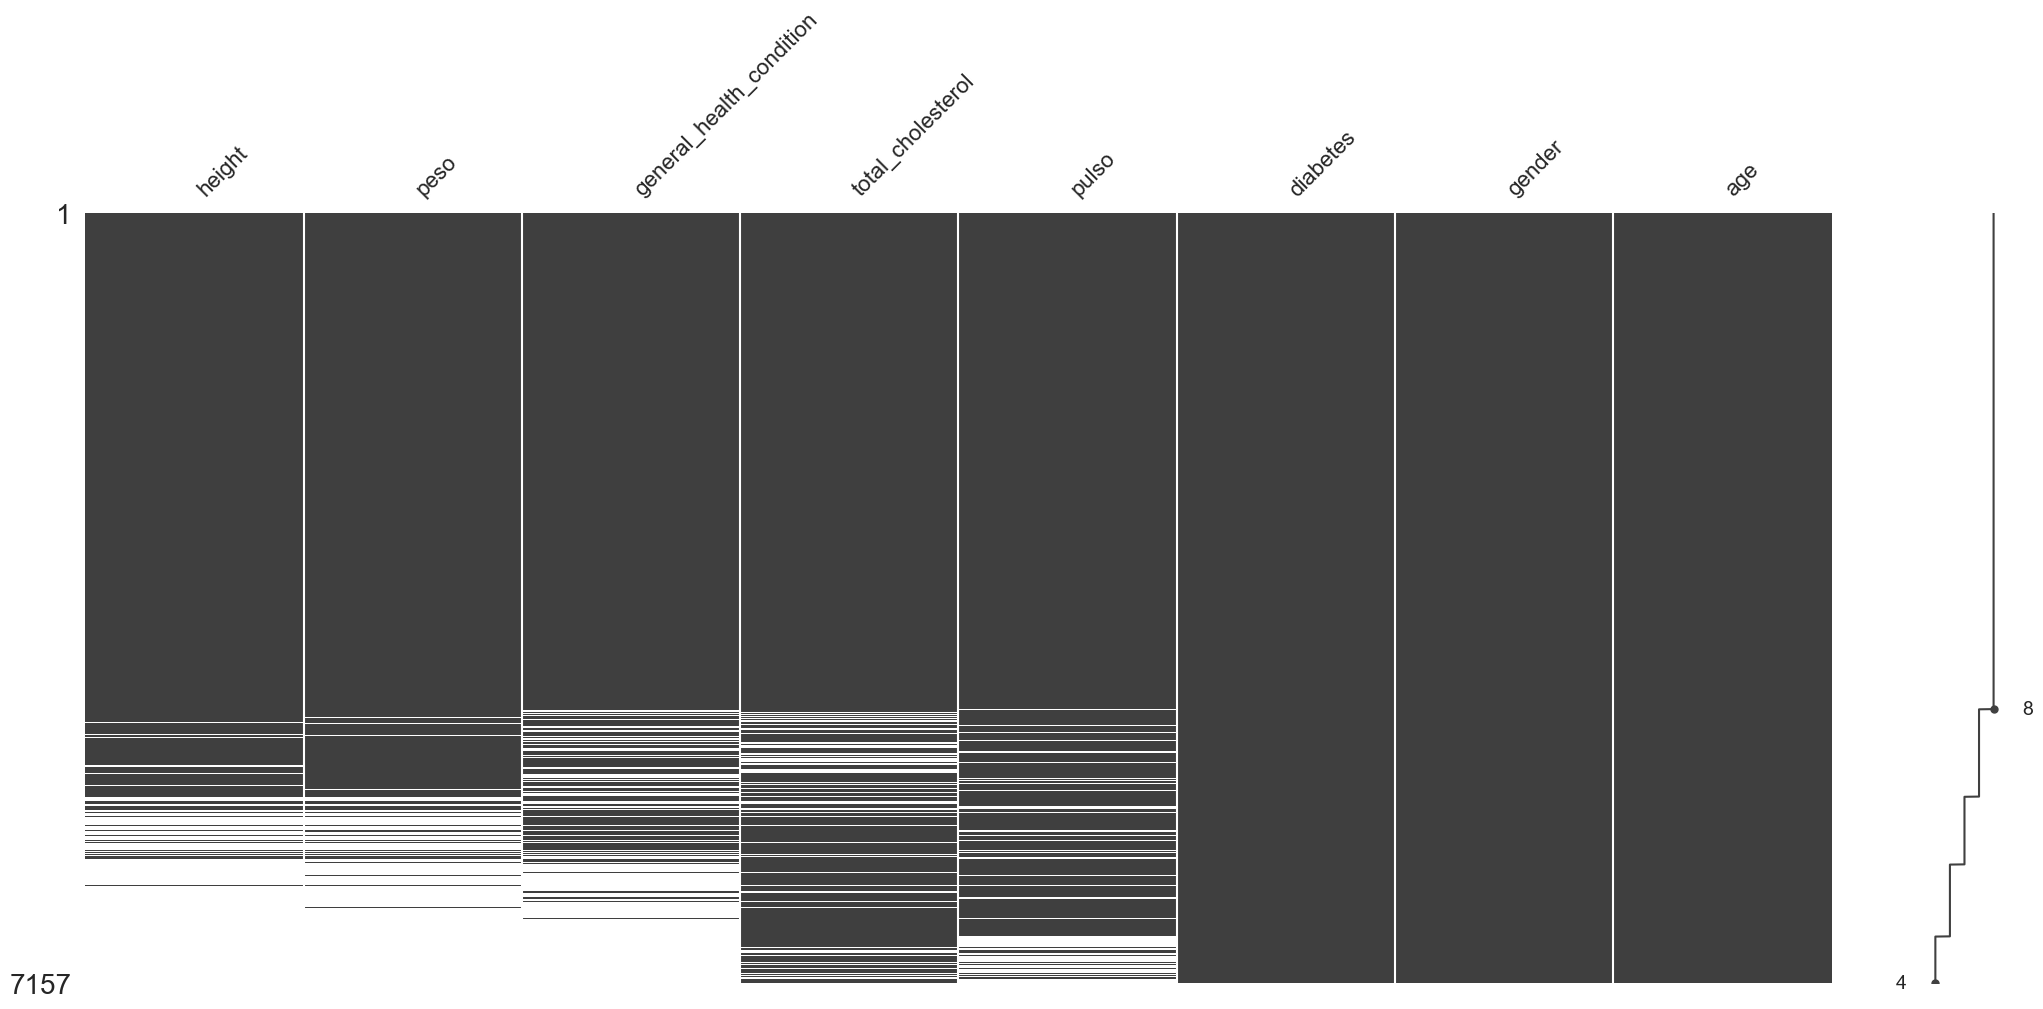

In [16]:
nhanes_raw_df= (
    nhanes.load.load_NHANES_data(year="2017-2018")
    .clean_names(case_type = "snake")
)

nhanes_raw_df.shape

# %% [markdown]
# ## Procesar los datos de NHANES

# %%
import numpy as np

nhanes_df = (
    nhanes_raw_df
    .select_columns(
        "general_health_condition",
        "age_in_years_at_screening",
        "gender",
        "current_selfreported_height_inches",
        "current_selfreported_weight_pounds",
        "doctor_told_you_have_diabetes",
        "60_sec_pulse30_sec_pulse2",
        "total_cholesterol_mgdl"
    )
    .rename_columns({
        "age_in_years_at_screening": "age",
        "current_selfreported_height_inches": "height",
        "current_selfreported_weight_pounds": "peso",
        "doctor_told_you_have_diabetes": "diabetes",
        "60_sec_pulse30_sec_pulse2": "pulso",
        "total_cholesterol_mgdl": "total_cholesterol"
    })
    .replace({
        "height": {9999: np.nan, 7777: np.nan},
        "peso": {9999: np.nan, 7777: np.nan},
        "diabetes": {"Borderline": np.nan}
    })
    .missing.sort_variables_by_missingness()
    .dropna(
        subset = ["diabetes"],
        how = "any"
    )
    .transform_column(
        column_name = "diabetes",
        function = lambda s: s.astype(int),
        elementwise = False
    )
)


# %% [markdown]
# ## Visualizar los valores faltantes

# %%
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .pipe(missingno.matrix, sort = "descending")
)


# %% [markdown]
# Analizando el gráfico, nos damos cuenta que hay variables que no tienen valores faltantes, osea que hay valores qu aparecen conjuntamente y son faltantes

# %%
(
    nhanes_df
    .missing.sort_variables_by_missingness()
    .missing.missing_upsetplot()
)

# %% [markdown]
# Reviando la relación de los valores faltantes, podriamos imputarlo o eliminarlo

# %%
nhanes_df

# %%
# Aplica dropna pero sin sobrescribir con Axes
nhanes_df = (
    nhanes_df
    .dropna(  # Eliminamos las filas que tengan TODOS esos datos faltantes en las columnas
        subset=["pulso", "total_cholesterol", "general_health_condition", "peso", "height"], 
        how="all"
    )
)

# Aplica el método personalizado .missing
nhanes_df = nhanes_df.missing.sort_variables_by_missingness()

# Luego visualiza, pero sin sobrescribir nhanes_df
missingno.matrix(nhanes_df, sort="descending")


# %% [markdown]
# ## Eliminar valores faltantes

# %%
nhanes_df.shape


## Consideración y evaluación de los distintos tipos de valores faltantes

![](missing_data_action.jpeg)

## Evaluación del mecanismo de valores faltantes por prueba de _t-test_

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
<code>two-sided</code>: las <b>medias</b> de las distribuciones subyacentes a las muestras son <b>desiguales</b>.<br>
<code>less</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>menor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
<code>greater</code>: la <b>media</b> de la distribución subyacente a la <b>primera</b> muestra es <b>mayor</b> que la media de la distribución subyacente a la <b>segunda</b> muestra.<br>
    </p>
</div>

In [26]:
female_weight, male_weight = (
    nhanes_df
    .select_columns("gender", "peso")
    .transform_column(
        "peso",
        lambda x : x.isna(),
        elementwise = False 
    )
    .groupby("gender")
    .peso
    .pipe(
        lambda df: (
            df.get_group("Female"),
            df.get_group("Male")
        )
    )
)

female_weight,  male_weight

#Prueba estadistica para determinar si existe una diferencia o no entre la presencia y ausencia de valores de peso

scipy.stats.ttest_ind(
    a = female_weight,
    b = male_weight,
    alternative = "two-sided"
)

c:\Users\Admin\Documents\manejo_datos\Data-Handling-Course\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


TtestResult(statistic=np.float64(-0.3621032192538131), pvalue=np.float64(0.7172855918077239), df=np.float64(7155.0))

Es el valor del estadístico t (mide la diferencia entre las medias, estandarizada). Es cercano a 0, lo que sugiere poca o ninguna diferencia entre grupos.

* Si p < 0.05: se rechaza la hipótesis nula → hay evidencia de diferencia significativa.
* Si p ≥ 0.05: no se rechaza la hipótesis nula → no hay evidencia de diferencia significativa.

p = 0.7173 ⟶ muy superior a 0.05 → NO hay evidencia de que la proporción de valores faltantes en "peso" difiera significativamente entre hombres y mujeres.

No existe una diferencia estadísticamente significativa entre los géneros ("Male" y "Female") en cuanto a la presencia de valores faltantes en la columna peso.



## Amplía tu conjunto de herramientas para explorar valores faltantes

c:\Users\Admin\Documents\manejo_datos\Data-Handling-Course\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


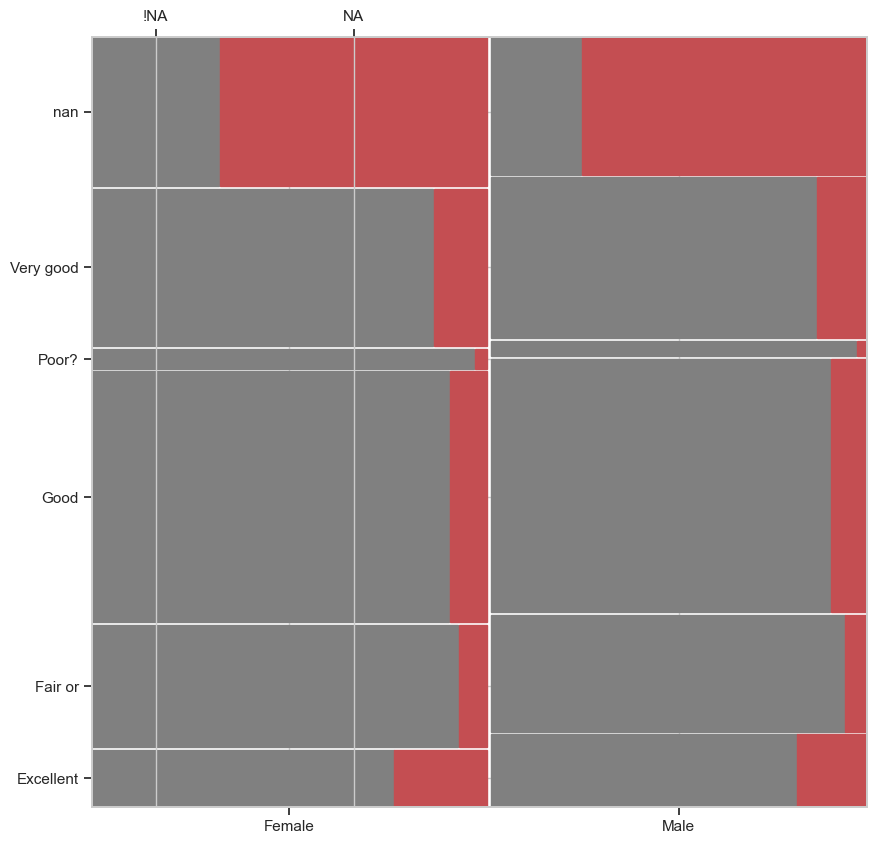

In [35]:
fig, ax = plt.subplots(figsize = (10, 10))

(
    nhanes_df
    .select_columns("peso", "general_health_condition", "gender")
    .assign(
        peso = lambda df: df.peso.isna().replace([True, False], ["NA", "!NA"])
    )
    # Cuántas apariciones existen por cada combinacion de las 3 columas 
    .groupby(
        ["gender", "general_health_condition", "peso"],
        dropna = False,
        as_index = True
    )
    .size()
    .pipe(
        lambda df: mosaic(
            data = df,
            properties = lambda key: {"color": "r" if "NA" in key else "gray"},
            horizontal = True,
            axes_label = True,
            title = "",
            labelizer = lambda key: "",
            ax = ax

        )
    )
);

## Tratamiento de variables categóricas para imputación de valores faltantes

In [36]:
#1. Siempre debemos de crear una copia del DataFrame
nhanes_copy_df = nhanes_df.copy(deep = True)

### Codificación ordinal

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Información</b>
    <p>
    Una codificación ordinal <b>implica</b> mapear cada etiqueta (categoría) única a un valor entero. A su vez, la codificación ordinal también es conocida como codificación entera.
    </p>
</div>

#### Ejemplo

Dado un conjunto de datos con dos características, encontraremos los valores únicos por cataracterística y los transformaremos utilizando una codificación ordinal.

In [39]:
#Encoder que agrupa la informacion y la coficia
encoder = sklearn.preprocessing.OrdinalEncoder()

# Definir nuestra variable
X = [["Male"], ["Female"],["Female"]]
X

[['Male'], ['Female'], ['Female']]

In [ ]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [41]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [42]:
encoder.inverse_transform([[1], [0], [0]])

array([['Male'],
       ['Female'],
       ['Female']], dtype=object)

#### Aplicando la codificación ordinal a todas tus variables categóricas

In [50]:
#1. Encontrar nuestras variables categoricas
categorical_columns = nhanes_df.select_dtypes(include =[ object, "category"])

In [53]:
# 2. componer instrucciones de transformación de los datos
categorical_transform = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder = "passthrough" # ¿qué quiero hacer con las otras variables? Ignorarlas
)

In [54]:
(
    pd.DataFrame(
        categorical_transform.fit_transform(nhanes_df),
        columns  = categorical_transform.get_feature_names_out()
    )
)

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed

In [55]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder

# ✅ Paso previo: lista de columnas categóricas
categorical_columns = nhanes_df.select_dtypes(include="category").columns.tolist()

# ✅ Transformador
categorical_transform = make_column_transformer(
    (OrdinalEncoder(), categorical_columns),
    remainder="passthrough"
)

# ✅ Transformar y convertir a DataFrame
transformed_df = pd.DataFrame(
    categorical_transform.fit_transform(nhanes_df),
    columns=categorical_transform.get_feature_names_out()
)

transformed_df.head()


,remainder__height,remainder__peso,remainder__general_health_condition,remainder__total_cholesterol,remainder__pulso,remainder__diabetes,remainder__gender,remainder__age
0,63.0,165.0,Good,157.0,52.0,0,Female,66.0
1,68.0,145.0,Very good,148.0,82.0,0,Male,18.0
2,NaN,NaN,Good,189.0,100.0,0,Male,13.0
3,62.0,200.0,NaN,176.0,74.0,0,Female,75.0
4,69.0,142.0,Very good,238.0,62.0,0,Male,56.0


In [62]:
nhanes_transformed_df = (
    pd.DataFrame(
        categorical_transform.fit_transform(nhanes_df),
        columns = categorical_transform.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainderencoder__")
    )
)

nhanes_transformed_df

c:\Users\Admin\Documents\manejo_datos\Data-Handling-Course\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,remainder__height,remainder__peso,remainder__general_health_condition,remainder__total_cholesterol,remainder__pulso,remainder__diabetes,remainder__gender,remainder__age
SEQN,,,,,,,,
93705.0,63.0,165.0,Good,157.0,52.0,0,Female,66.0
93706.0,68.0,145.0,Very good,148.0,82.0,0,Male,18.0
93707.0,NaN,NaN,Good,189.0,100.0,0,Male,13.0
93709.0,62.0,200.0,NaN,176.0,74.0,0,Female,75.0
93711.0,69.0,142.0,Very good,238.0,62.0,0,Male,56.0
...,...,...,...,...,...,...,...,...
102949.0,72.0,180.0,Excellent,201.0,96.0,0,Male,33.0
102953.0,65.0,218.0,Fair or,182.0,78.0,0,Male,42.0
102954.0,66.0,150.0,Good,172.0,78.0,0,Female,41.0


### _One Hot Encoding_

In [63]:
# 1. Realizar copia
nhanes_transformed_df2 = nhanes_df.copy(deep = True)

### `pandas.get_dummies()` vs `skelearn.preprocessing.OneHotEncoder()`

#### `pandas.get_dummies()`

In [67]:
(
    nhanes_transformed_df2
    .select_columns("general_health_condition")
    #.head(10)
    .pipe(pd.get_dummies)
)

#Este metodo aunque es util, se queda corto en cuanto a practicidad, pues al modelarlo como tal no siempre tendremos las mismas dimensiones

c:\Users\Admin\Documents\manejo_datos\Data-Handling-Course\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good
SEQN,,,,,
93705.0,False,False,True,False,False
93706.0,False,False,False,False,True
93707.0,False,False,True,False,False
93709.0,False,False,False,False,False
93711.0,False,False,False,False,True
...,...,...,...,...,...
102949.0,True,False,False,False,False
102953.0,False,True,False,False,False
102954.0,False,False,True,False,False


#### `skelearn.preprocessing.OneHotEncoder()`

In [68]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(),["gender"]),
    (sklearn.preprocessing.OneHotEncoder(), ["general_health_condition"]),
    remainder = "passthrough"

)

In [70]:
nhanes_transformed_df2 = (
    pd.DataFrame(
        transformer.fit_transform(nhanes_df),
        columns = transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainderencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("onehotencoder__")
    )
)

nhanes_transformed_df2

c:\Users\Admin\Documents\manejo_datos\Data-Handling-Course\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `pd.DataFrame.rename` instead.
  return method(self._obj, *args, **kwargs)


,gender,general_health_condition_Excellent,general_health_condition_Fair or,general_health_condition_Good,general_health_condition_Poor?,general_health_condition_Very good,general_health_condition_nan,remainder__height,remainder__peso,remainder__total_cholesterol,remainder__pulso,remainder__diabetes,remainder__age
SEQN,,,,,,,,,,,,,
93705.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,63.0,165.0,157.0,52.0,0.0,66.0
93706.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,68.0,145.0,148.0,82.0,0.0,18.0
93707.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,NaN,189.0,100.0,0.0,13.0
93709.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,62.0,200.0,176.0,74.0,0.0,75.0
93711.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,69.0,142.0,238.0,62.0,0.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
102949.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,72.0,180.0,201.0,96.0,0.0,33.0
102953.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,65.0,218.0,182.0,78.0,0.0,42.0
102954.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,66.0,150.0,172.0,78.0,0.0,41.0


In [72]:
# podemos acceder a estas categorias
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [74]:
#Tambien podemos obtener su inversa:

(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .inverse_transform(
        X = [[0, 0, 1, 0, 0, 0]]
    )
)

array([['Good']], dtype=object)

## Tipos de imputación de valores faltantes

![](imputation_methods.png)

## Imputación de un único valor (media, mediana, moda)

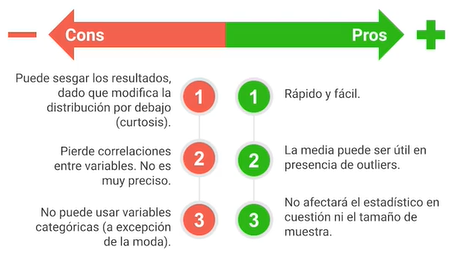

In [77]:
(
    nhanes_df
    #1. Transformar la columna con función de janitor
    .transform_column(
        "height",
        lambda x: x.fillna(x.mean()),
        elementwise = False
    )
    .height
    .mean()
)

np.float64(66.25655976676386)

In [85]:
import seaborn as sns

In [87]:
(
    nhanes_df
    .select_columns("height", "peso")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        peso = lambda df: df.peso.fillna(value = df.peso.mean())
    )
    .missing.scatter_imputation_plot(
        x = "height", 
        y = "peso"
    )
)

c:\Users\Admin\Documents\manejo_datos\Data-Handling-Course\venv\Lib\site-packages\pandas_flavor\register.py:164: FutureWarning: This function will be deprecated in a 1.x release. Please use `jn.select` instead.
  return method(self._obj, *args, **kwargs)


NameError: name 'sns' is not defined

## Imputación por llenado hacia atrás e imputación por llenado hacia adelante

### `fillna()` vs `ffill()` o `bfill()`

#### Recomendaciones al imputar valores utilizando `ffill()` o `bfill()`

> Imputación dentro de dominios e imputación a través de variables correlacionadas

## Imputación por interpolación

## Imputación por algoritmo de vecinos más cercanos (KNN)

### Ordenamiento por cantidad de variables faltantes

## Imputación basada en modelos

## Imputaciones Múltiples por Ecuaciones Encadenadas (MICE)

## Transformación inversa de los datos

## Continúa aprendiendo sobre el manejo de valores faltantes

<div class="alert alert-success">
    <b style="font-size: 1.5em;">✅ ¡Felicidades por terminar el curso!</b>
    <p>
    ¡Tu progreso es increíble! ¡Ahora eres capaz de llevar tus análisis al siguiente nivel! La barrera de los valores faltantes ya no es una limitante extrema para tu trabajo. Tú puedes explorar valores faltantes, eliminarlos e imputarlos siendo consciente de las ventajas y desventajas de cada método elegido. ¡Fantástico!
    </p>
    <p>
    <b>¿Cómo puedo continuar mi aprendizaje en el análisis de valores faltantes?</b>
    Poner en práctica lo aprendido es una excelente opción. Por lo tanto, te recomiendo repetir este curso utilizando la totalidad de los datos del <i>National Health and Nutrition Examination Survey</i>. Con este proyecto, serás capaz de explorar y analizar una cantidad de valores faltantes variadas. Podrás probar distintos algoritmos y estrategias. 
    </p>
    <p>
    De tal forma de que, una vez consigas tu conjunto de datos final, puedas proceder a la exploración definitiva del conjunto de datos para extraer ideas y respuestas a preguntas de tu interés. Incluso, y por qué no, podrías explorar la posibilidad de crear modelos predictivos para la diabetes. Las opciones son ilimitadas. Bienvenido al mundo de la Ciencia de Datos.
    </p>
    <p>
    Con mucha alegría por tu logro,
    Jesús Vélez Santiago
    </p>
</div>

## Información de sesión

In [ ]:
session_info.show()